<a href="https://colab.research.google.com/github/daveking63/Jupyter-iPython-Notebooks-Deep-Learning-Notes/blob/master/DLPython2ndCh3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes from Deep Learning with Python 2nd Edition - Chapter 3

In [0]:
# To do anything in tensorflow you need tensors. Tensors need to be created with initial values

import tensorflow as tf

x = tf.ones(shape=(2,1))
print(x)

x = tf.zeros(shape=(2,1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


In [0]:
x = tf.random.normal(shape=(3,1), mean=0.,stddev=1.)
print(x)

x = tf.random.uniform(shape=(3,1), minval=0.,maxval=1.)
print(x)

tf.Tensor(
[[ 0.11099514]
 [-0.06829678]
 [-1.0480335 ]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.9585936]
 [0.5085423]
 [0.3895259]], shape=(3, 1), dtype=float32)


In [0]:
# numpy arrays are assignable

import numpy as np
x = np.ones(shape=(2,2))
print(x)

[[1. 1.]
 [1. 1.]]


In [0]:
# tensorflow tensors are not assignable
# e.g. in assignment directly below second line will not work

#x = tf.ones(shape=(2,2))
#x[0,0] = 0.

# to overcome restraint, we use variables

v = tf.Variable(initial_value=tf.random.normal(shape=(3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.2621828],
       [0.5402336],
       [0.8591136]], dtype=float32)>


In [0]:
# assigning a value to a variable

v.assign(tf.ones((3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>


In [0]:
#assigning a value to a subset of a variable

v[0,0].assign(3.)
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>


In [0]:
# using assign_add (or assign_sub)

v.assign_add(tf.ones((3,1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

In [0]:
import tensorflow as tf

a = tf.ones((2,2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a,b)
e *= d
print(e)

tf.Tensor(
[[4. 4.]
 [4. 4.]], shape=(2, 2), dtype=float32)


In [0]:
# Using GradientTape

input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
  result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


In [0]:
# Using GradientTape with constant input

input_const = tf.constant(3.)
with tf.GradientTape() as tape:
  tape.watch(input_const)
  result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


In [0]:
# Using nested gradient tapes to comput 2nd order gradients

time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
    acceleration = outer_tape.gradient(speed, time)
print(position)
print(speed)
print(acceleration)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(9.8, shape=(), dtype=float32)


# Linear Classifier in TensorFlow

In [0]:
# generating 2 classes of random points in a 2D plane

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

print("- samples", negative_samples.shape)
print(negative_samples[:5,:])
print ("+ samples",positive_samples.shape)
print(positive_samples[:5,:])

- samples (1000, 2)
[[-1.48341651  2.67885518]
 [-0.26148361  2.06277465]
 [ 0.58698612  4.52911095]
 [-1.5180079   1.68547571]
 [ 0.31268907  3.53761549]]
+ samples (1000, 2)
[[ 1.66447105 -1.20329581]
 [ 3.21267485 -0.62774216]
 [ 0.95925478 -1.01457103]
 [ 2.65935682  0.07172287]
 [ 3.53905799 -0.12507951]]


In [0]:
# stacking 2 classes into an array of (2000,2)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

print("inputs", inputs.shape)
print(inputs[:5,:])

inputs (2000, 2)
[[-1.4834166   2.6788552 ]
 [-0.2614836   2.0627747 ]
 [ 0.5869861   4.529111  ]
 [-1.5180079   1.6854757 ]
 [ 0.31268907  3.5376155 ]]


In [0]:
# generating corresponding targes (0 and 1)

targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype='float32'),np.ones((num_samples_per_class, 1), dtype='float32')))
print(targets.shape)
print(targets[0:5])

(2000, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


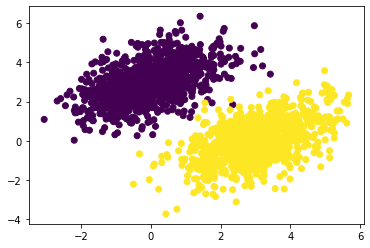

In [0]:
# plotting the two point classes

import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

Now lets create a linear classifier to separate these 2 clusters. The classifier is an affine transformation (prediction = W * input +b) trained to minimise mean squared error between predictions and actual targets

In [0]:
# creating the linear classifier variables
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

# forward pass function
def model(inputs):
  return tf.matmul(inputs, W) + b

# loss function
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets-predictions)
  return tf.reduce_mean(per_sample_losses)

In [0]:
# training step function

learning_rate = 0.1
def training_step(inputs, targets):
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = square_loss(predictions, targets)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
  W.assign_sub(grad_loss_wrt_W * learning_rate)
  b.assign_sub(grad_loss_wrt_b * learning_rate)
  return loss

In [0]:
# batch training loop
for step in range(20):
  loss = training_step(inputs, targets)
  print('Loss at step %d: %.4f' % (step, loss))

Loss at step 0: 0.3480
Loss at step 1: 0.1090
Loss at step 2: 0.0905
Loss at step 3: 0.0833
Loss at step 4: 0.0778
Loss at step 5: 0.0731
Loss at step 6: 0.0688
Loss at step 7: 0.0648
Loss at step 8: 0.0613
Loss at step 9: 0.0580
Loss at step 10: 0.0550
Loss at step 11: 0.0523
Loss at step 12: 0.0499
Loss at step 13: 0.0477
Loss at step 14: 0.0456
Loss at step 15: 0.0438
Loss at step 16: 0.0421
Loss at step 17: 0.0405
Loss at step 18: 0.0391
Loss at step 19: 0.0379


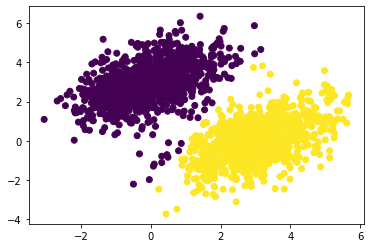

In [0]:
# graph of predicted values

predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

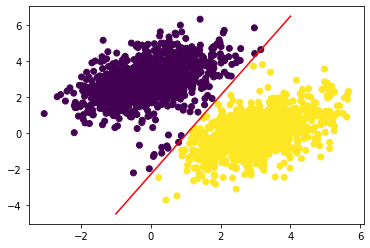

In [0]:
# plotting predicted value line

x = np.linspace(-1, 4, 100)
y = - W[0] / W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, '-r')
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)